In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install torchvision 

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install torchsummary

In [1]:
import torch
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
def create_data_generator(batch_size = 32, root = "data"):
    train_dataset = torchvision.datasets.MNIST(root = root,
                                             train = True,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    test_dataset = torchvision.datasets.MNIST(root = root,
                                             train = False,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size = batch_size,
                                             shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size = batch_size,
                                             shuffle = False)
    return train_loader, test_loader

In [3]:
class CharacterNetwork(nn.Module):
    def __init__(self, hidden_dims=[512, 128, 64]):
        super(CharacterNetwork, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.network_dims = [32 * 7 * 7] + hidden_dims + [10] 
        self.layers = []
        for i, dim in enumerate(self.network_dims[1:]):
            prev_dim = self.network_dims[i]
            dense = nn.Linear(in_features=prev_dim, out_features=dim, bias=True)
            if i < len(self.network_dims[1:]) - 1:
                activation = nn.ReLU() 
            else:
                activation = nn.Softmax(dim=1) # Last Layer
            self.layers += [dense, activation]

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        # Input x is [B, 1, 28, 28] where B is the batch size

        x = self.conv_layers(x)  
        x = x.view(x.size(0), -1)  
        for layer in self.layers[:-1]:
            x = layer(x)

        # Apply the final activation (Softmax) only in evaluation mode
        if not self.training:
            x = self.layers[-1](x)

        return x

In [16]:
cuda = torch.cuda.is_available()
batch_size = 64
train_loader, test_loader = create_data_generator(batch_size)
model = CharacterNetwork()
print(model)

CharacterNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers): ModuleList(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)


In [21]:
from torchsummary import summary
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

model = CharacterNetwork().to(device) 
summary(model, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 512]         803,328
              ReLU-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 882,698
Trainable params:

In [22]:
def train(model, loader, n_epochs = 1, learning_rate = 0.1):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()

    #optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
    optim = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    log_losses = []
    log_accuracy = []
    model.train()
    
    for epoch in range(1, n_epochs + 1):
        for idx, (images, labels) in enumerate(loader):
            if cuda:
                images = images.cuda()
                labels = labels.cuda()
                
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            
            
            predictions = torch.argmax(outputs, 1)
            accuracy = (predictions == labels).float().mean() * 100.
            
            loss = loss.item() # Convert to Python Scalar
            accuracy = accuracy.item() # Convert to Python Scalar
            log_losses.append(loss)
            log_accuracy.append(accuracy)
            
            if idx % 500 == 0:
                print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(loader), loss, accuracy))

    return model, log_losses, log_accuracy

In [23]:
# Training Model
model, losses, accuracies = train(model, train_loader, n_epochs = 50, learning_rate = 0.0001)

# Saving Model
print("Saving Model to CharacterModel.pth")
torch.save(model.state_dict(), "CharacterModel.pth")

Epoch [1/50]. Iter [1/938]. Loss: 2.30. Accuracy: 12.50
Epoch [1/50]. Iter [501/938]. Loss: 0.46. Accuracy: 79.69
Epoch [2/50]. Iter [1/938]. Loss: 0.15. Accuracy: 96.88
Epoch [2/50]. Iter [501/938]. Loss: 0.19. Accuracy: 93.75
Epoch [3/50]. Iter [1/938]. Loss: 0.22. Accuracy: 93.75
Epoch [3/50]. Iter [501/938]. Loss: 0.11. Accuracy: 96.88
Epoch [4/50]. Iter [1/938]. Loss: 0.08. Accuracy: 96.88
Epoch [4/50]. Iter [501/938]. Loss: 0.10. Accuracy: 96.88
Epoch [5/50]. Iter [1/938]. Loss: 0.01. Accuracy: 100.00
Epoch [5/50]. Iter [501/938]. Loss: 0.09. Accuracy: 96.88
Epoch [6/50]. Iter [1/938]. Loss: 0.05. Accuracy: 98.44
Epoch [6/50]. Iter [501/938]. Loss: 0.04. Accuracy: 98.44
Epoch [7/50]. Iter [1/938]. Loss: 0.04. Accuracy: 98.44
Epoch [7/50]. Iter [501/938]. Loss: 0.03. Accuracy: 100.00
Epoch [8/50]. Iter [1/938]. Loss: 0.04. Accuracy: 98.44
Epoch [8/50]. Iter [501/938]. Loss: 0.10. Accuracy: 96.88
Epoch [9/50]. Iter [1/938]. Loss: 0.05. Accuracy: 98.44
Epoch [9/50]. Iter [501/938]. 

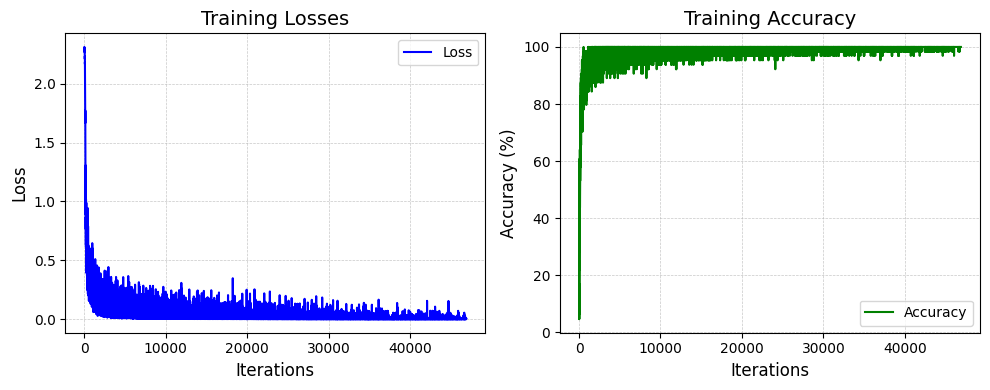

In [24]:
# Visualize Training Losses and Accuracy with Background Grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figure size

# Training Losses Plot
ax1.plot(losses, color='blue', label='Loss')
ax1.set_title("Training Losses", fontsize=14)
ax1.set_xlabel("Iterations", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  
ax1.legend()

# Training Accuracy Plot
ax2.plot(accuracies, color='green', label='Accuracy')
ax2.set_title("Training Accuracy", fontsize=14)
ax2.set_xlabel("Iterations", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  
ax2.legend()

plt.tight_layout()  
plt.show()

In [33]:
def evaluate(model, loader):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()
        
    model.eval()
    model.load_state_dict(torch.load("CharacterModel.pth"))

    total_accuracy = 0.0
    for idx, (images, labels) in enumerate(test_loader):
        if cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = model(images)
        
        predictions = torch.argmax(outputs, 1)
        accuracy = (predictions == labels).float().mean() * 100.
        
        accuracy = accuracy.item() # Convert to Python Scalar
        
        total_accuracy += accuracy
        
        if idx % 200 == 0:
            print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))
        
    print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))

In [64]:
# Evaluate Model 
evaluate(model, test_loader)

/tmp/ipykernel_22307/3498967665.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


Iter [1/157]. Accuracy: 98.44
Final Accuracy: 99.06


In [65]:
def nms(boxes, scores, threshold):
    if len(boxes) == 0:
        return []

    # Convert boxes to NumPy array
    boxes = np.array(boxes)

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the bounding boxes by the confidence score
    indices = np.argsort(scores)[::-1]

    pick = []

    while len(indices) > 0:
        # Grab the index of the bounding box with the highest score
        i = indices[0]
        pick.append(i)

        # Compute the intersection over union (IoU)
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        iou = (w * h) / (areas[i] + areas[indices[1:]] - w * h)

        # Remove the bounding boxes with IoU greater than the threshold
        indices = np.delete(indices, np.concatenate(([0], np.where(iou > threshold)[0] + 1)))

    return pick


In [66]:
def find_contours(dimensions, img):
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check top 15 largest contours for character
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    img_res = []
    boxes = []
    scores = []
    
    for cntr in cntrs:
        # Detects contour in binary image and returns the coordinates of the rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # Filter contours by dimensions
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            # Extract character using the enclosing rectangle's coordinates
            char = img[intY:intY+intHeight, intX:intX+intWidth]

            # Calculate scaling factor to fit the character into a 28x28 canvas while preserving aspect ratio
            h, w = char.shape
            scale = min(20 / w, 20 / h)  
            new_w, new_h = int(w * scale), int(h * scale)
            
            # Resize the character to the new dimensions
            char_resized = cv2.resize(char, (new_w, new_h))
            
            # Create a 28x28 blank canvas and center the resized character
            char_canvas = np.zeros((28, 28), dtype=np.uint8)
            x_offset = (28 - new_w) // 2
            y_offset = (28 - new_h) // 2
            char_canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_resized
            
            boxes.append([intX, intY, intX + intWidth, intY + intHeight])
            scores.append(intWidth * intHeight)
            img_res.append(char_canvas)  # Store the centered and aspect-ratio-preserved character

    # Perform Non-Maximum Suppression
    boxes = np.array(boxes)
    scores = np.array(scores)
    keep = nms(boxes, scores, 0.1)

    return [img_res[i] for i in keep], [boxes[i] for i in keep]


In [74]:

def detect_characters(image_path, model):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()    
    model.eval()
    model.load_state_dict(torch.load("CharacterModel.pth"))
    
    image = cv2.imread(image_path)
    image = img_lp = cv2.resize(image, (333, 75))

    
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_HEIGHT = img_binary_lp.shape[0]
    LP_WIDTH = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [0, LP_WIDTH/2, LP_HEIGHT/6, 3*LP_HEIGHT/3]
    #----------------------------
    plt.figure()
    plt.imshow(img_binary_lp)
    plt.axis("off")
    
    #-----------------
    # Count foreground and background pixels
    total_pixels = img_binary_lp.size
    background_pixels = np.sum(img_binary_lp < 128)  # Pixels below 128 intensity (black)
    foreground_pixels = total_pixels - background_pixels

    # Revert the image if foreground is dominant
    if foreground_pixels > background_pixels:
        img_binary_lp = 255 - img_binary_lp
    #-----------------------------------------
    
    plt.figure()
    plt.imshow(img_binary_lp)
    plt.axis("off")
    
    # Get contours within cropped license plate
    char_list, boxes = find_contours(dimensions, img_binary_lp)
    for idx, char in enumerate(char_list):
        char = cv2.resize(char, (28, 28))
        
        plt.figure()
        plt.imshow(char)
        char = torch.from_numpy(char).resize(1, 1, 28, 28).float()
        
        if cuda:
            char = char.cuda()
        
        outputs = model(char)
        
        pred = torch.argmax(outputs, 1)[0].item()

        x1, y1, x2, y2 = boxes[idx]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
        image = cv2.putText(image, f'{pred}', (x1+2, y1+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure()
    plt.imshow(image[..., ::-1])
    plt.axis("off")

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))
/tmp/ipykernel_22307/309952365.py:

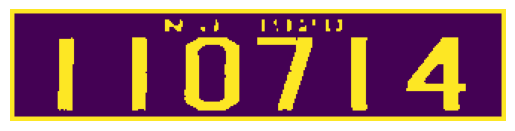

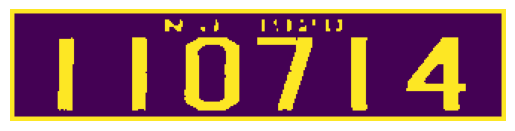

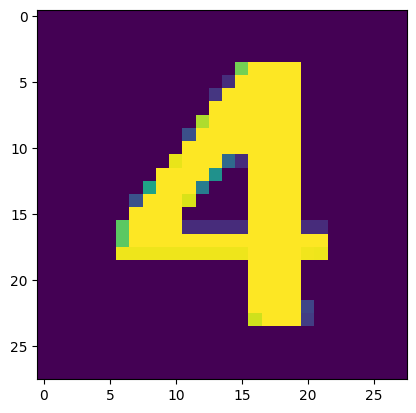

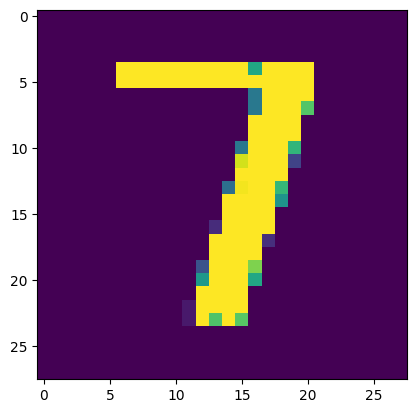

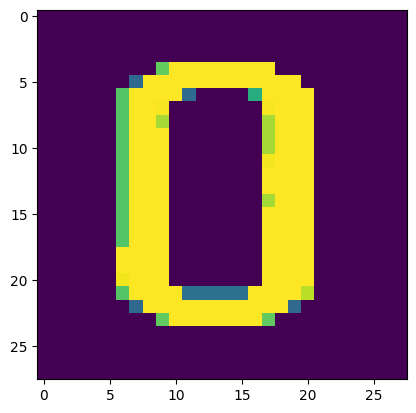

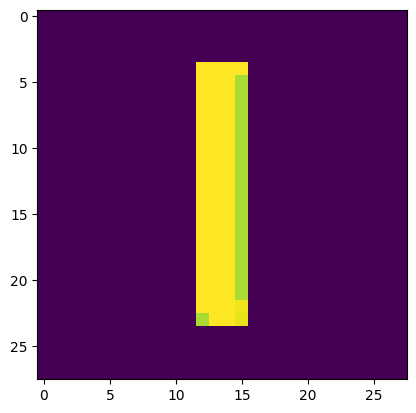

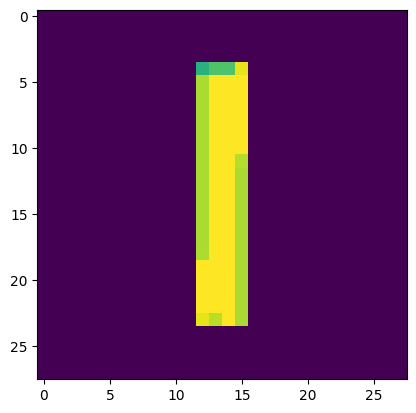

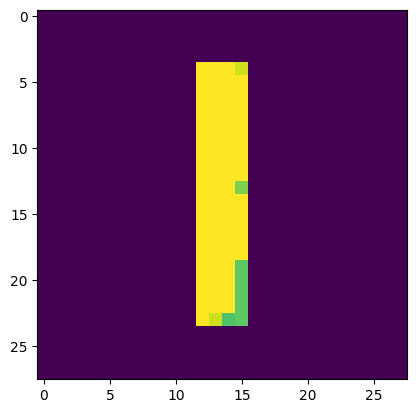

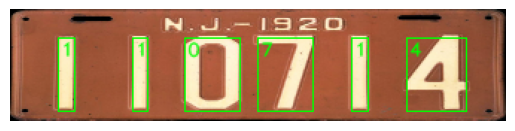

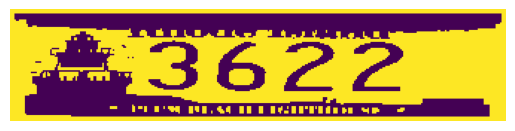

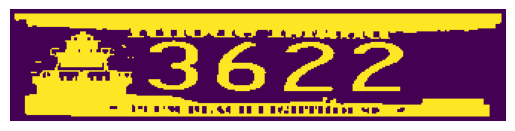

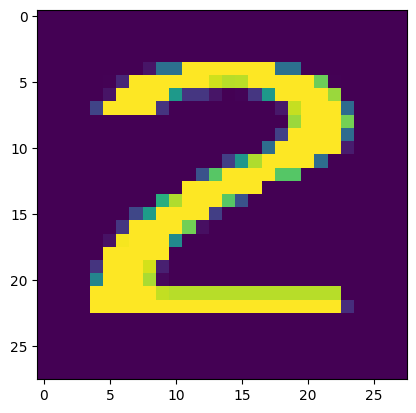

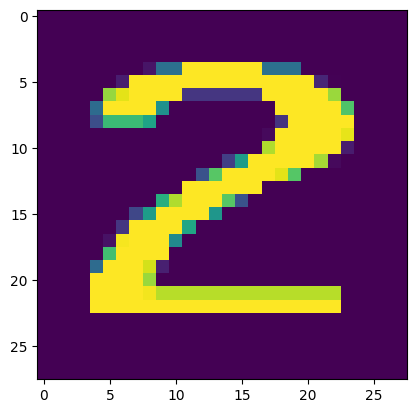

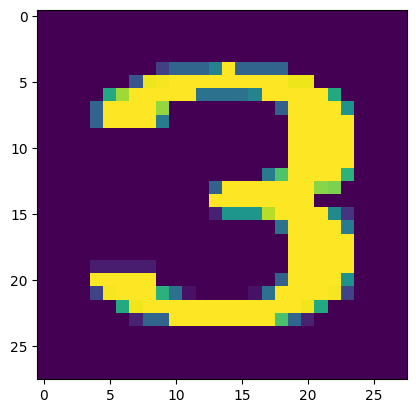

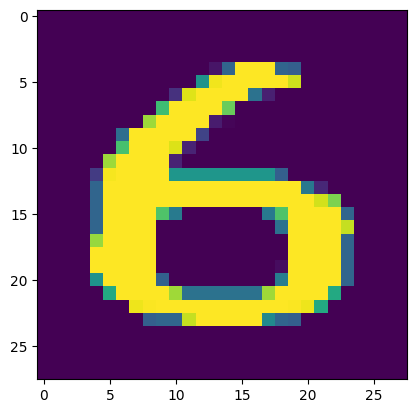

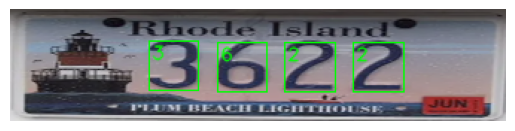

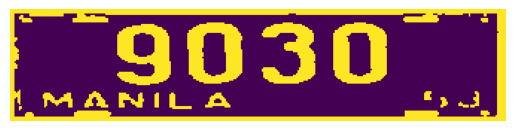

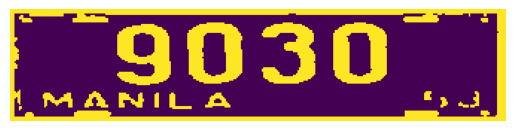

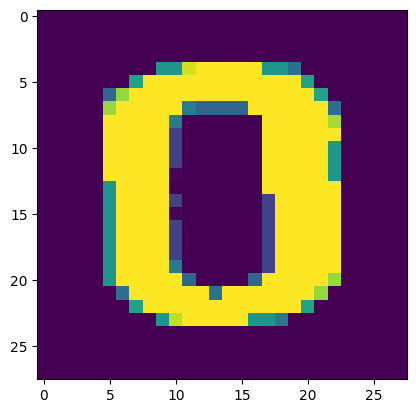

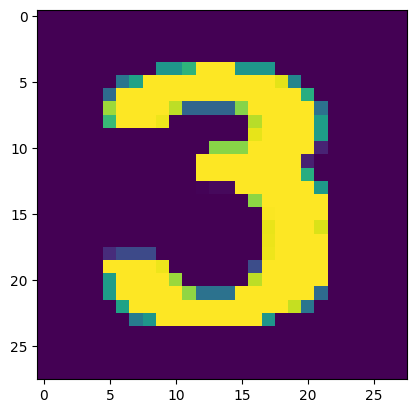

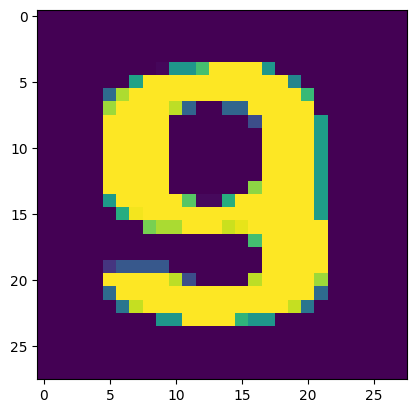

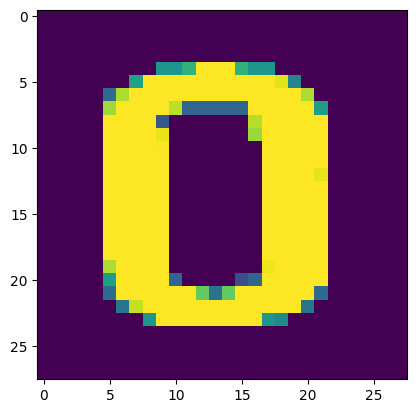

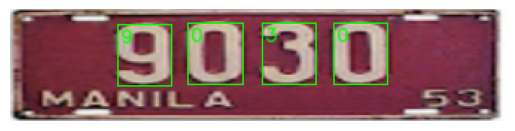

In [91]:
detect_characters("test_set/example1.jpeg", model)
detect_characters("test_set/example2.png", model)
detect_characters("test_set/example3.png", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


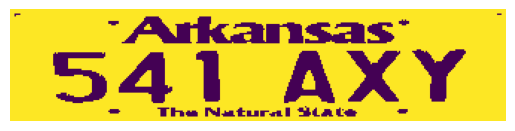

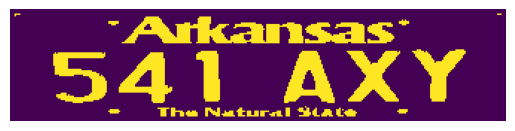

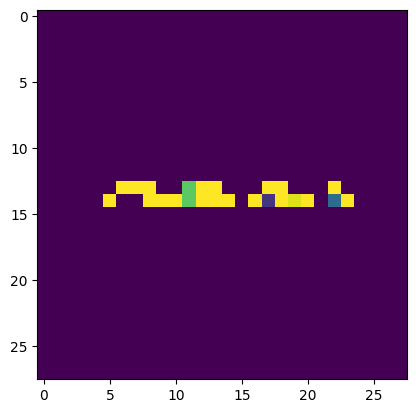

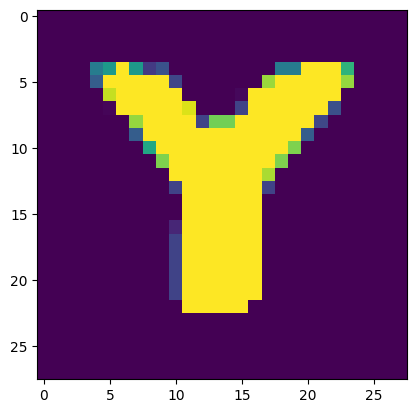

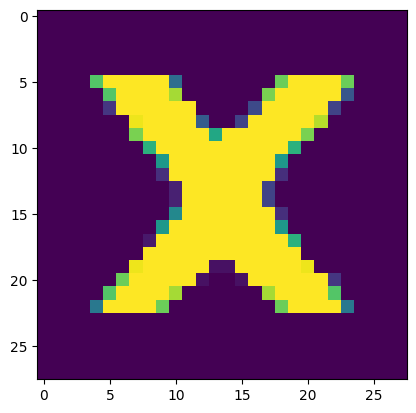

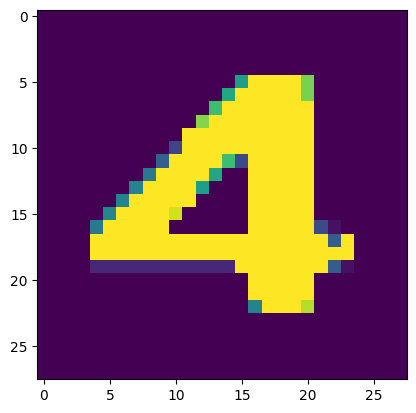

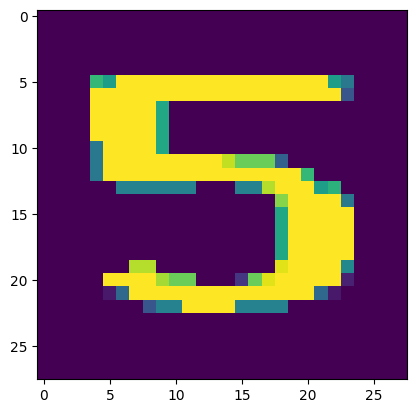

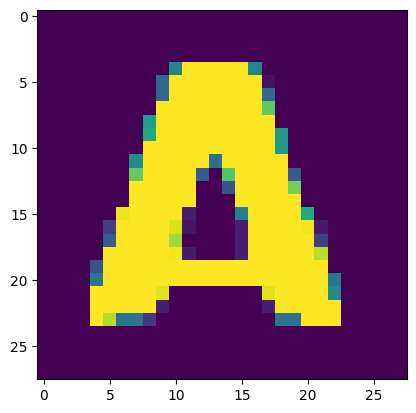

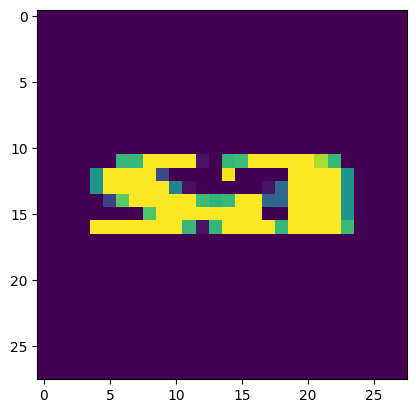

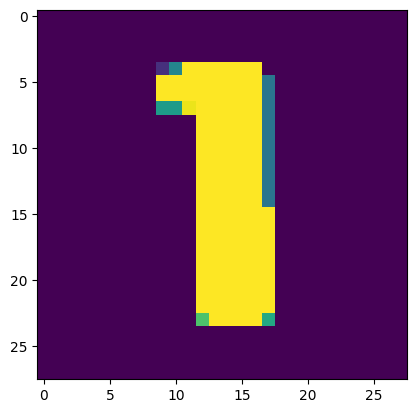

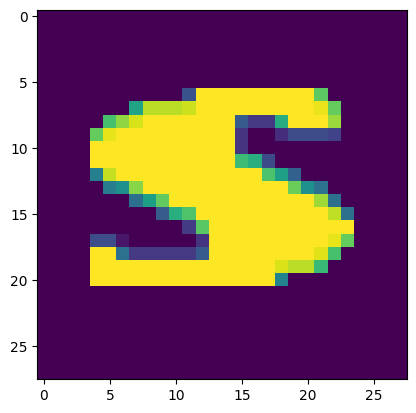

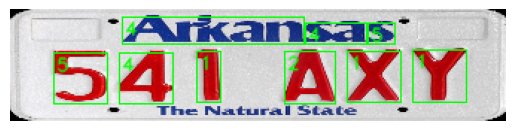

In [92]:
detect_characters("test_set/c1.png", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


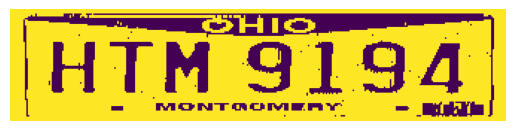

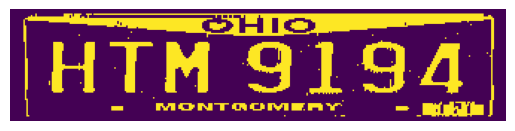

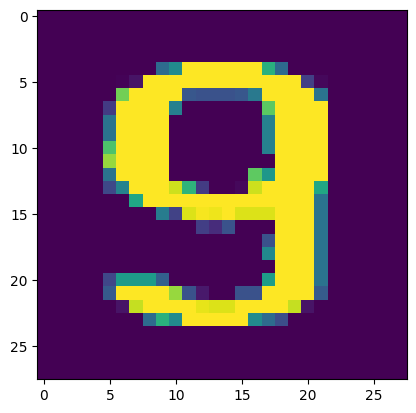

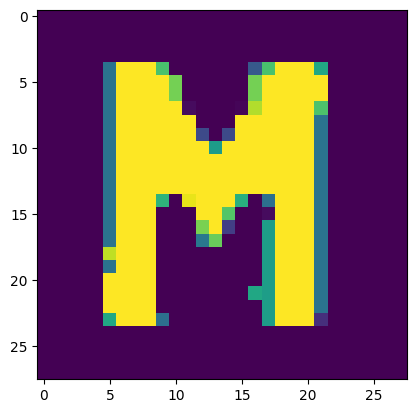

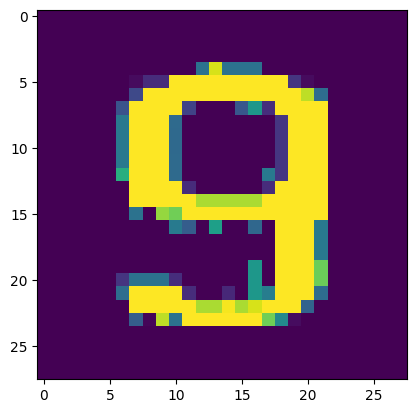

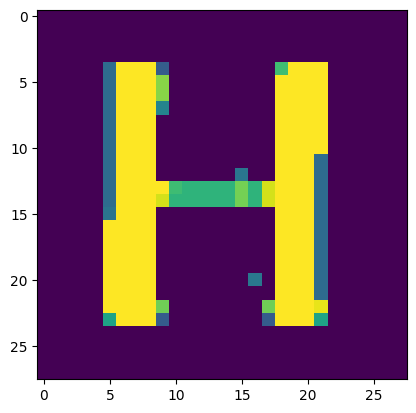

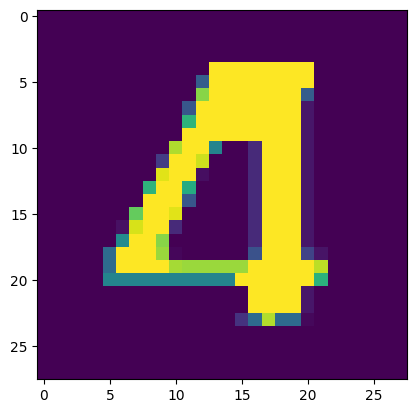

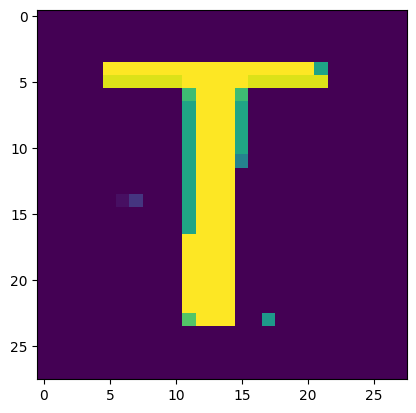

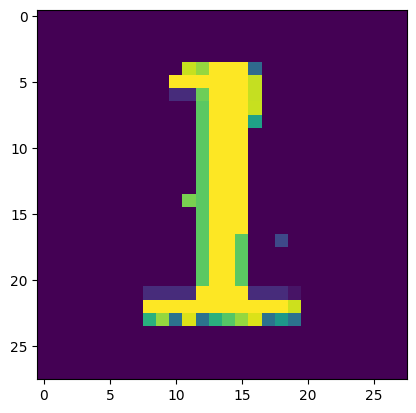

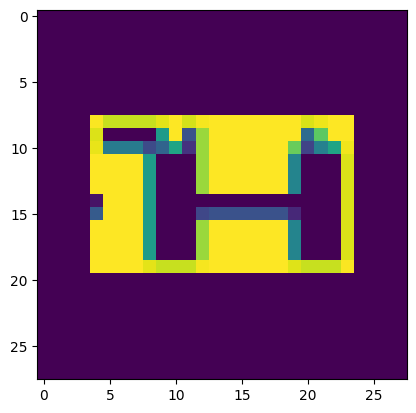

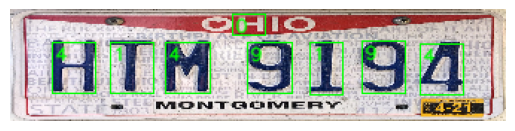

In [93]:
detect_characters("test_set/c2.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


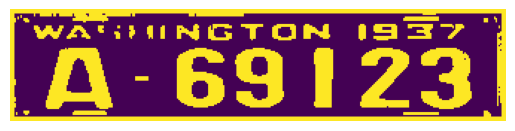

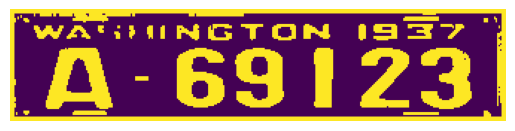

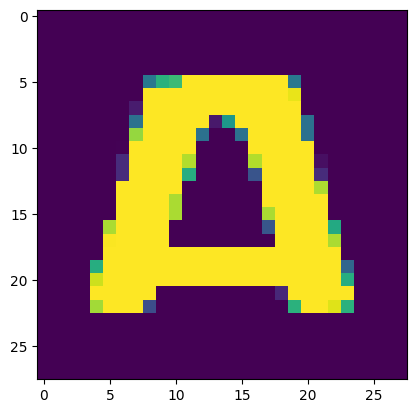

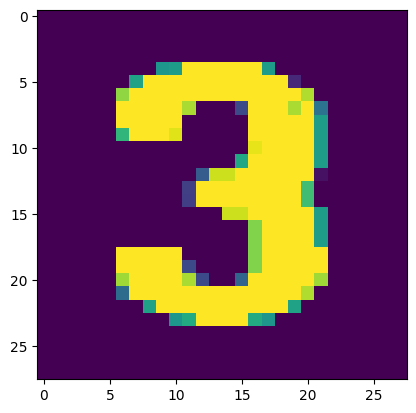

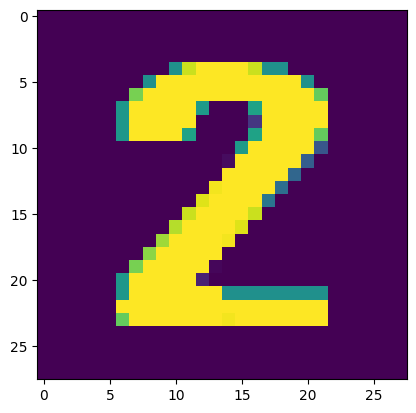

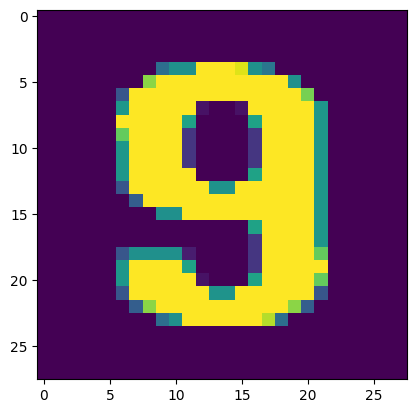

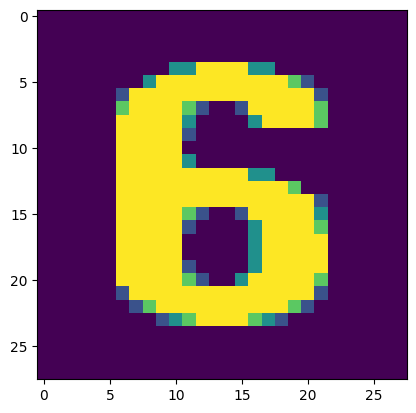

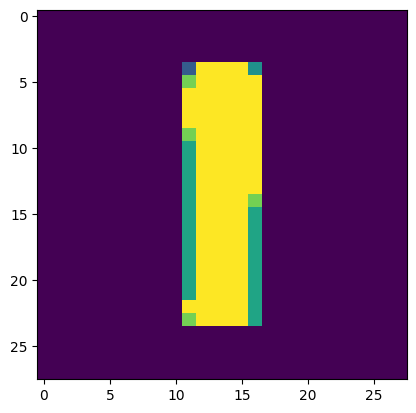

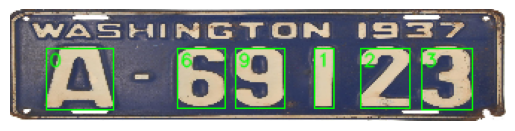

In [94]:
detect_characters("test_set/c3.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


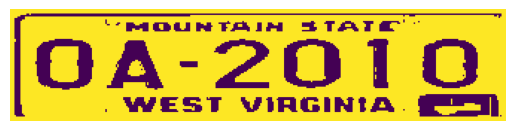

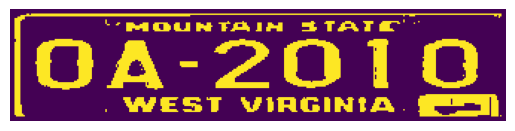

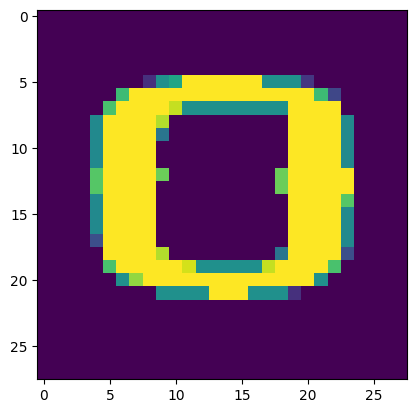

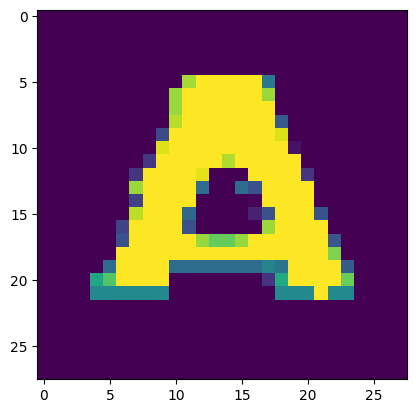

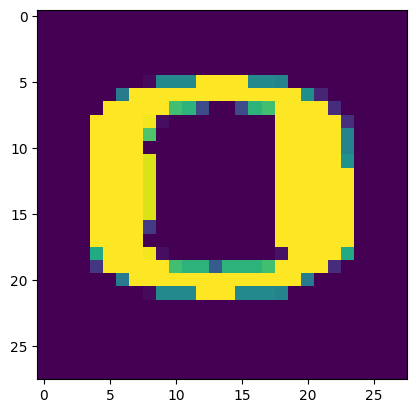

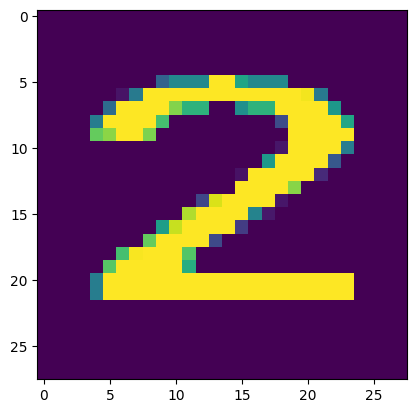

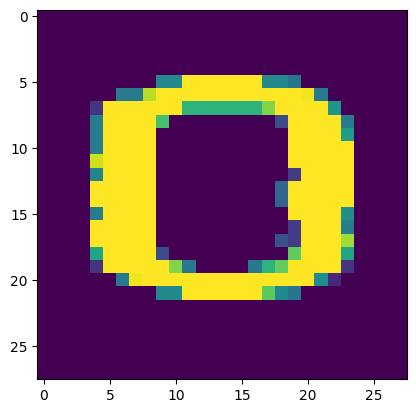

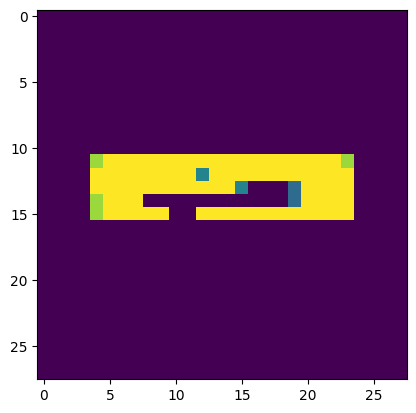

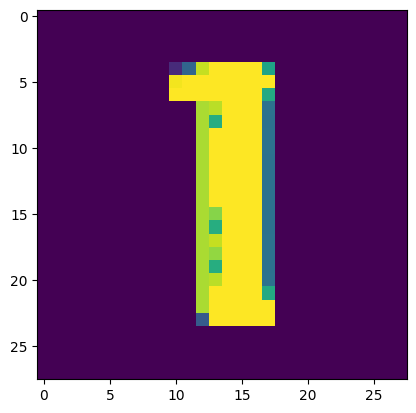

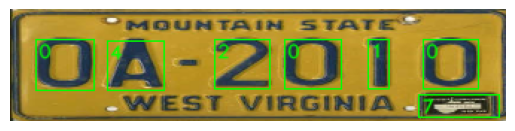

In [95]:
detect_characters("test_set/c4.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


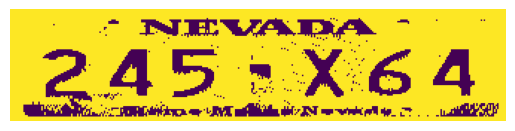

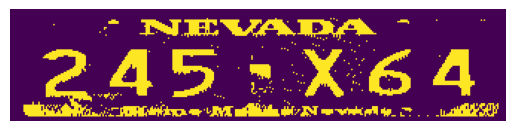

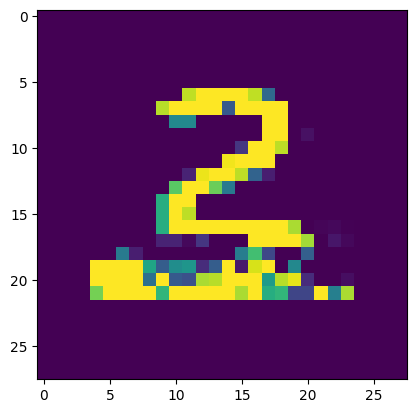

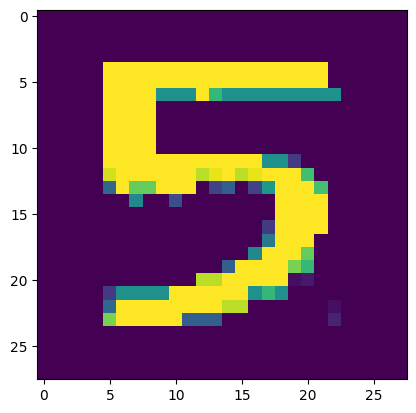

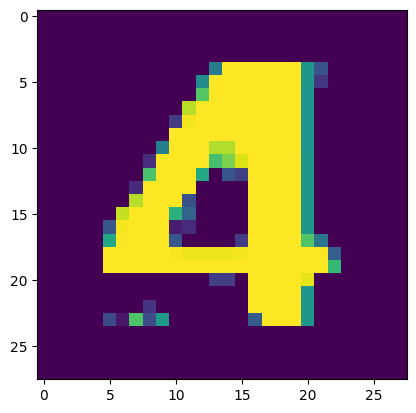

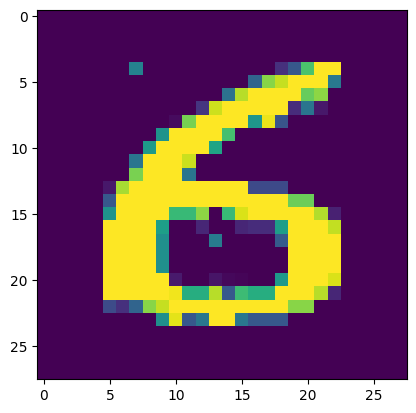

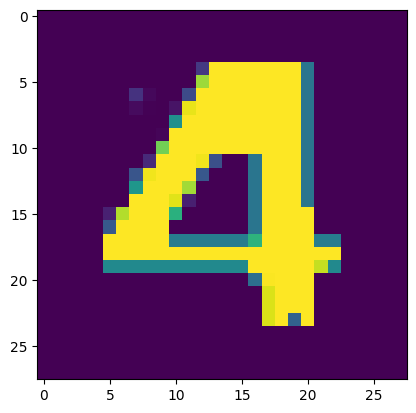

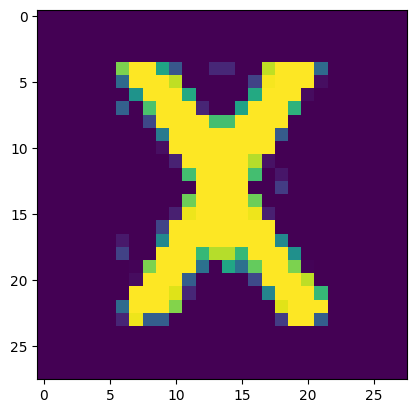

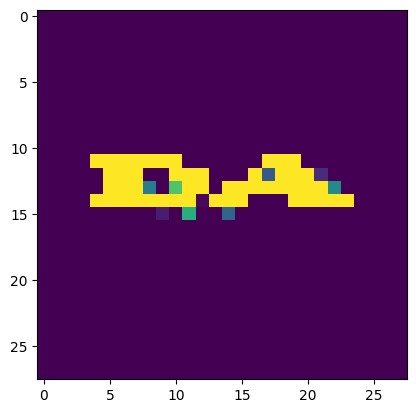

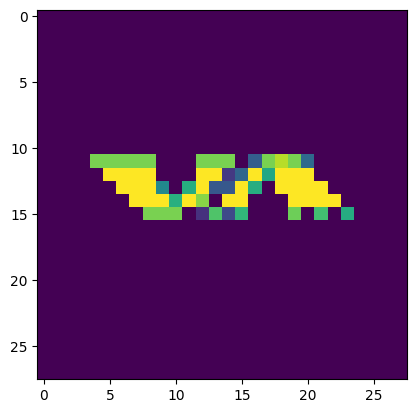

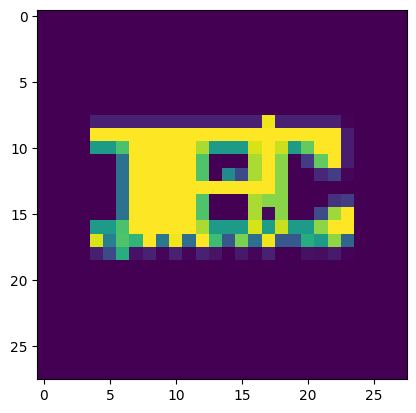

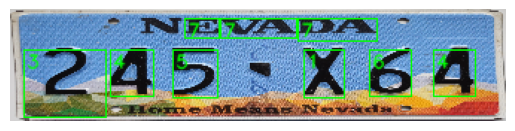

In [96]:
detect_characters("test_set/c5.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


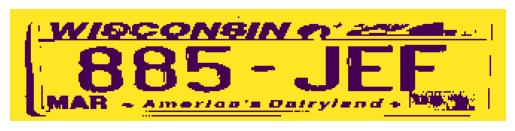

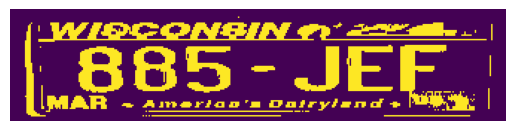

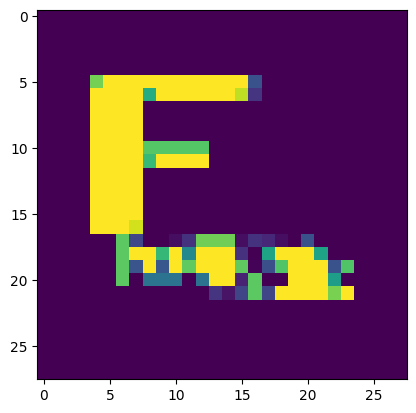

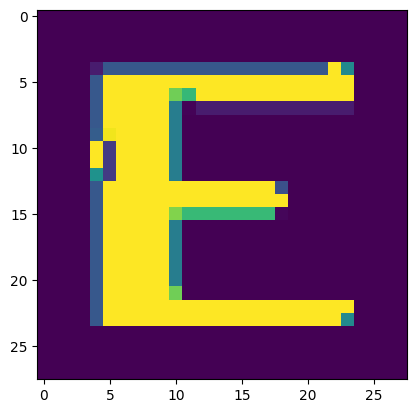

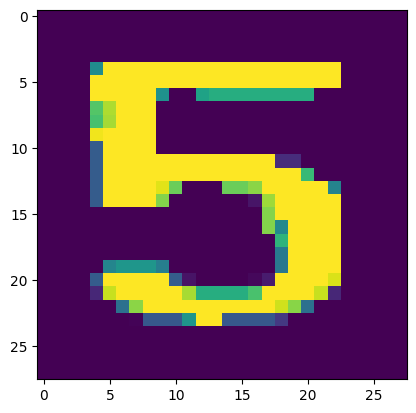

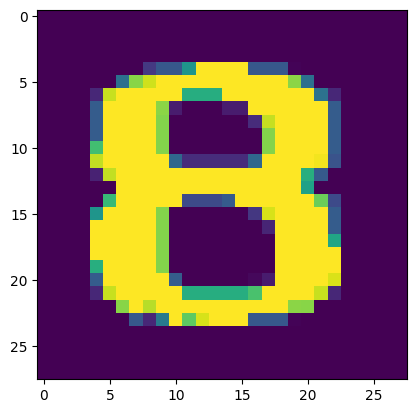

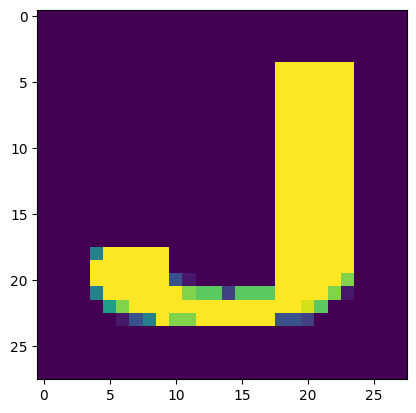

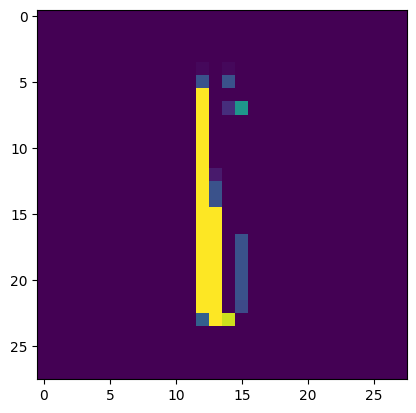

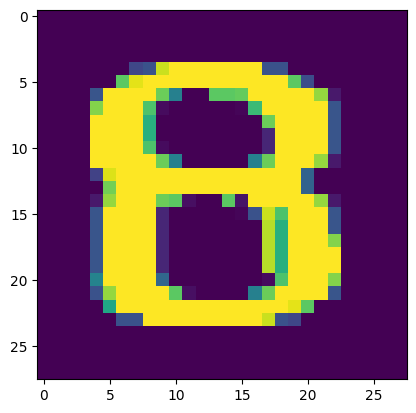

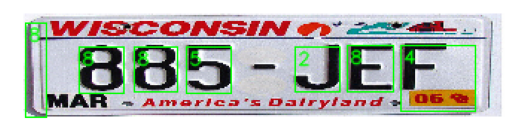

In [97]:
detect_characters("test_set/c6.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


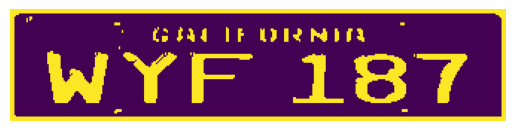

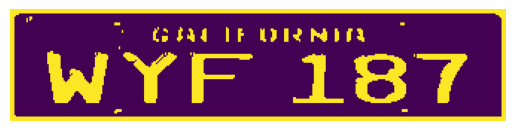

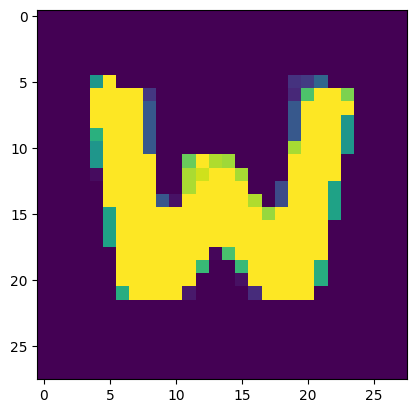

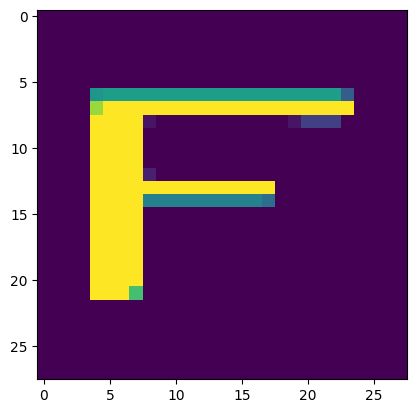

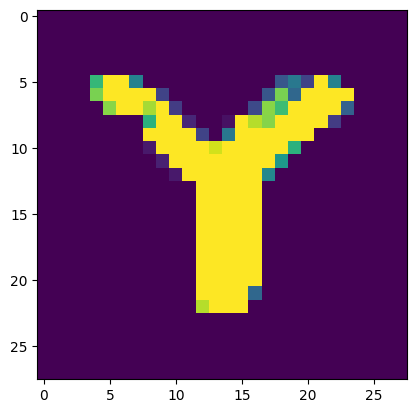

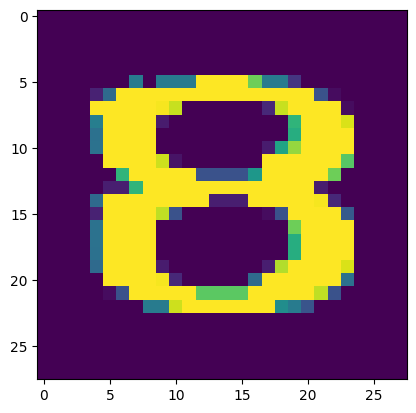

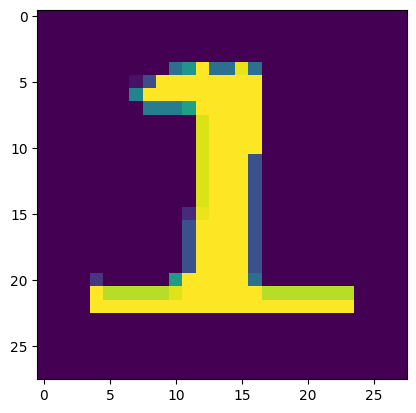

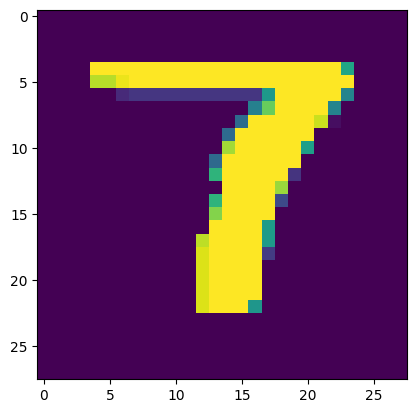

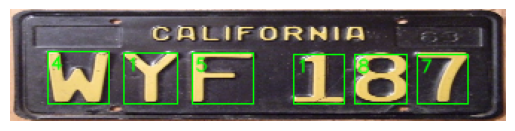

In [98]:
detect_characters("test_set/c7.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


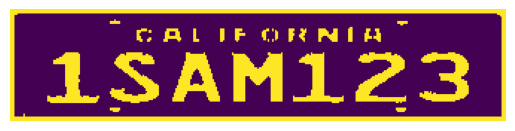

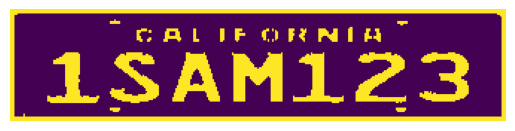

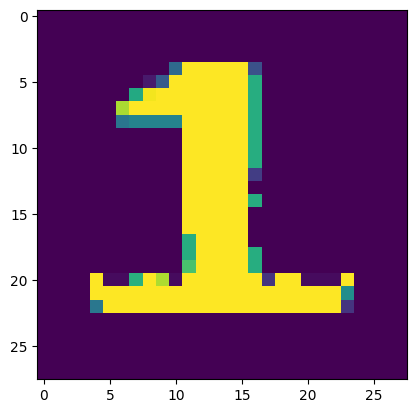

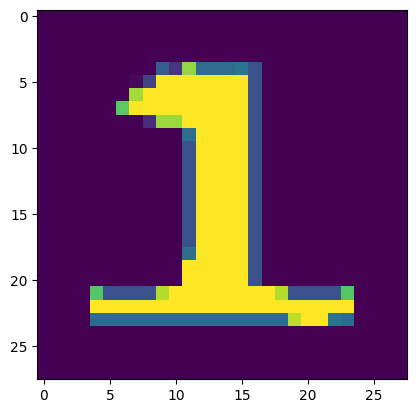

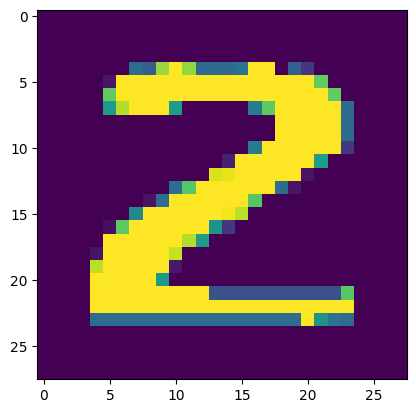

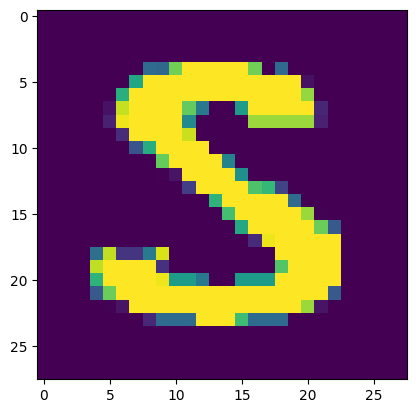

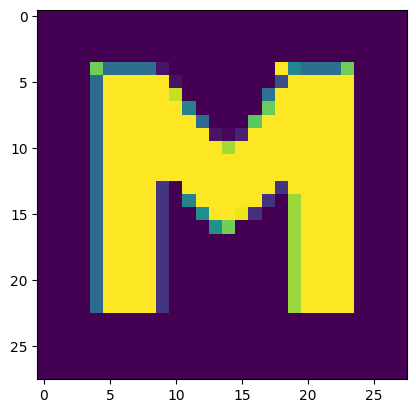

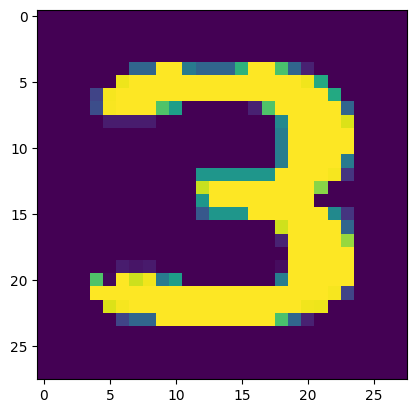

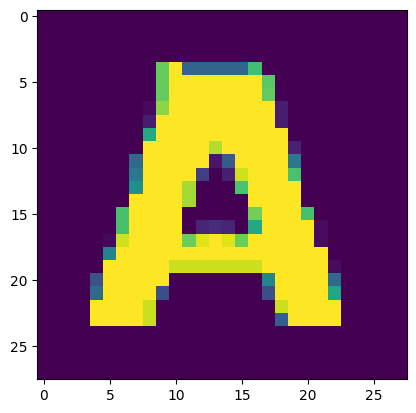

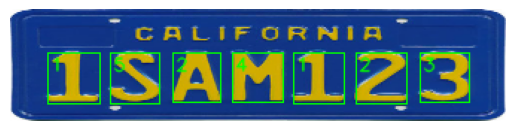

In [99]:
detect_characters("test_set/c8.jpg", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


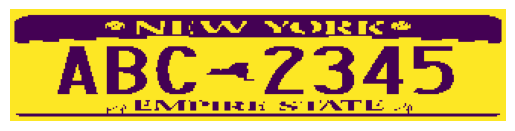

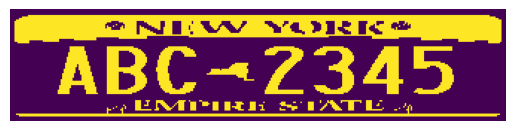

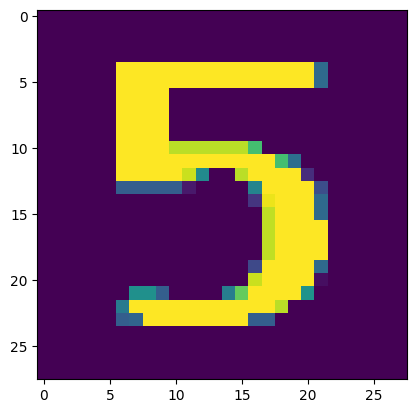

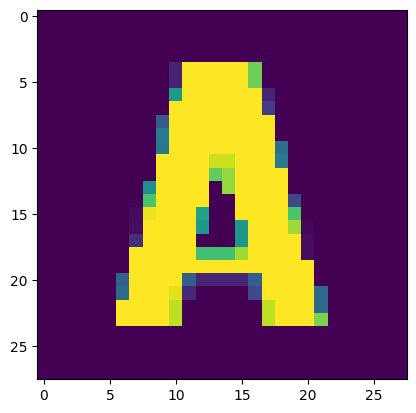

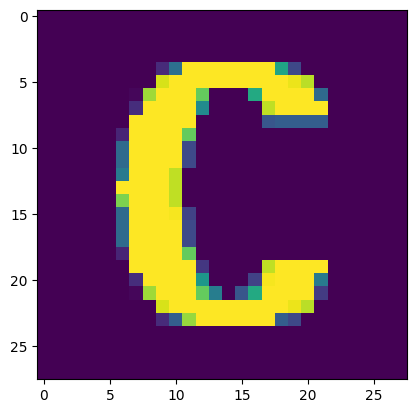

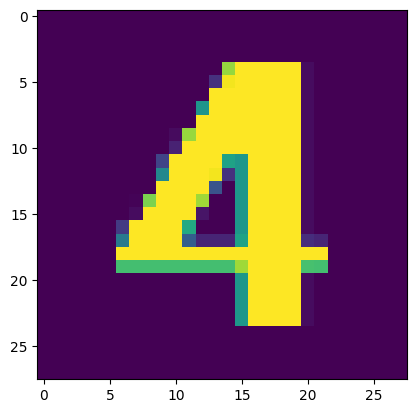

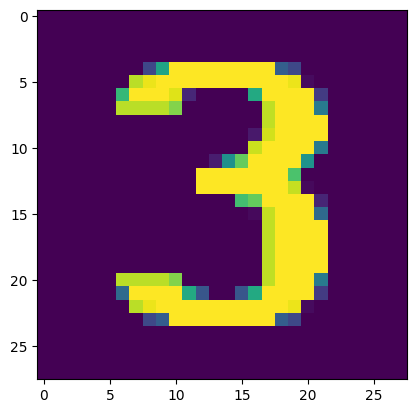

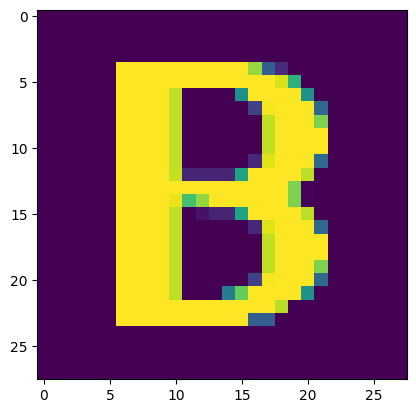

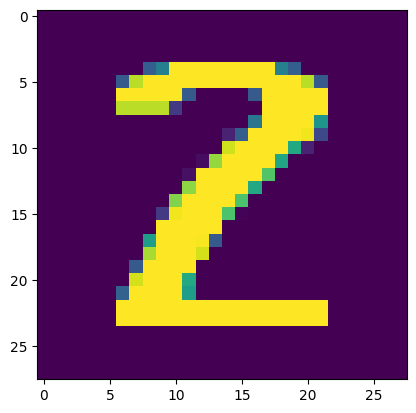

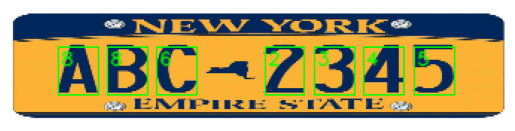

In [100]:
detect_characters("test_set/c9.webp", model)

/tmp/ipykernel_22307/309952365.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


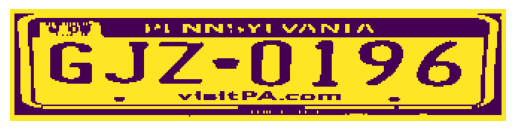

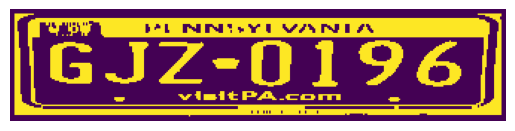

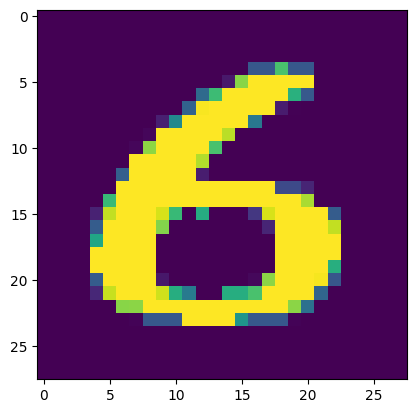

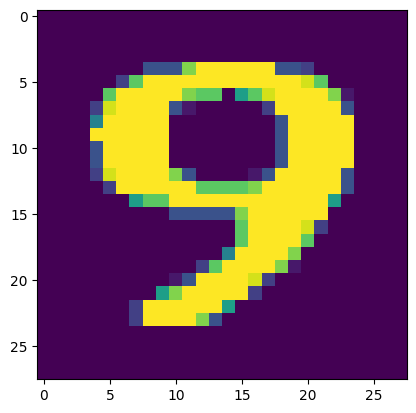

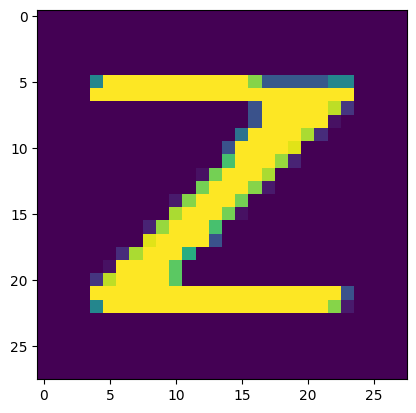

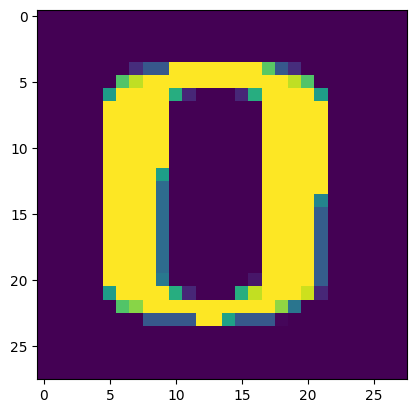

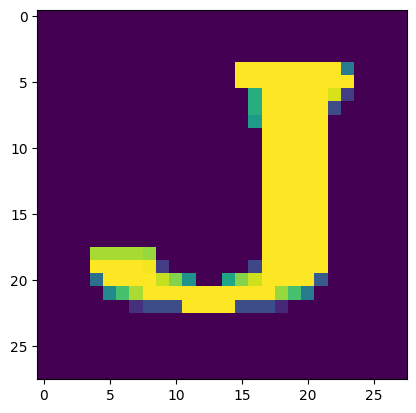

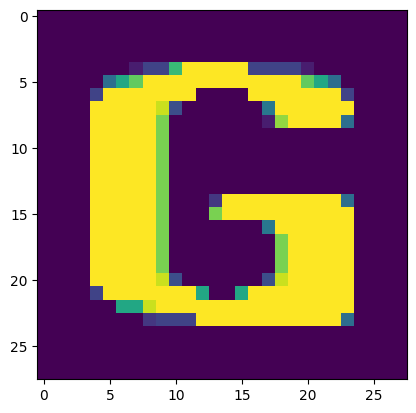

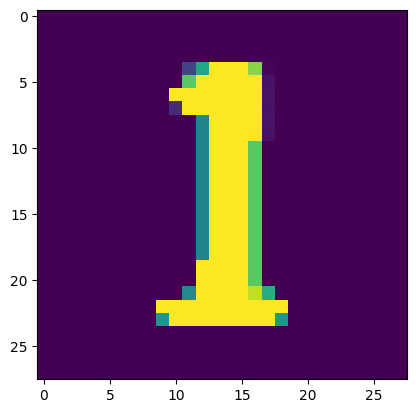

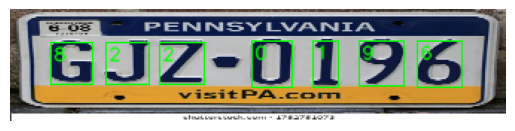

In [101]:
detect_characters("test_set/c10.webp", model)